In [1]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ------------------------------
# Step 1: Get weather data for Mumbai
# ------------------------------
API_KEY = 'a54554814d25c3ee171844a7596ad38a'
CITY = 'Mumbai'

url = f'https://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={API_KEY}&units=metric'
response = requests.get(url).json()

# Store the weather info in a list
weather_records = []
for item in response['list']:
    weather_records.append({
        'time': pd.to_datetime(item['dt_txt']),
        'temp': item['main']['temp'],
        'humidity': item['main']['humidity'],
        'rain': item.get('rain', {}).get('3h', 0)
    })

df = pd.DataFrame(weather_records)

# ------------------------------
# Step 2: Create flood labels
# ------------------------------
# Simple rule for demo: if it rained a lot in last 12 hours and humidity is high, mark flood
df['cum_rain'] = df['rain'].rolling(window=4, min_periods=1).sum()  # 12 hours
df['flood'] = ((df['cum_rain'] > 15) & (df['humidity'] > 85)).astype(int)

features = ['temp', 'humidity', 'rain']
target = 'flood'

# Scale features to 0-1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

# ------------------------------
# Step 3: Make sequences for LSTM
# ------------------------------
seq_len = 12        # look at past 36 hours
pred_gap = 4        # predict 12 hours ahead

X, y = [], []
for i in range(len(df) - seq_len - pred_gap):
    X.append(scaled[i:i+seq_len])
    y.append(df[target].iloc[i+seq_len+pred_gap-1])

X, y = np.array(X), np.array(y)

# ------------------------------
# Step 4: Build and train LSTM
# ------------------------------
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, len(features))))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=30, batch_size=16, validation_split=0.2)

# ------------------------------
# Step 5: Predict flood for next 12 hours
# ------------------------------
last_seq = scaled[-seq_len:]
last_seq = last_seq.reshape((1, seq_len, len(features)))

prob = model.predict(last_seq)[0][0]
if prob > 0.5:
    print(f"⚠️ Flood likely in Mumbai in next 12 hours! Prob: {prob:.2f}")
else:
    print(f"✅ No flood expected in Mumbai. Prob: {prob:.2f}")


Epoch 1/30


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 906ms/step - accuracy: 0.2171 - loss: 0.7034 - val_accuracy: 1.0000 - val_loss: 0.6460
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8882 - loss: 0.6571 - val_accuracy: 1.0000 - val_loss: 0.5957
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9090 - loss: 0.6177 - val_accuracy: 1.0000 - val_loss: 0.5553
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8882 - loss: 0.5892 - val_accuracy: 1.0000 - val_loss: 0.5146
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8882 - loss: 0.5586 - val_accuracy: 1.0000 - val_loss: 0.4685
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9090 - loss: 0.5179 - val_accuracy: 1.0000 - val_loss: 0.4206
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8882 - loss: 0.4938 - val_accuracy: 1.0000 - val_loss: 0.3716
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9090 - loss: 0.4475 - val_accuracy: 1.0000 - val_loss: 0.3188
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


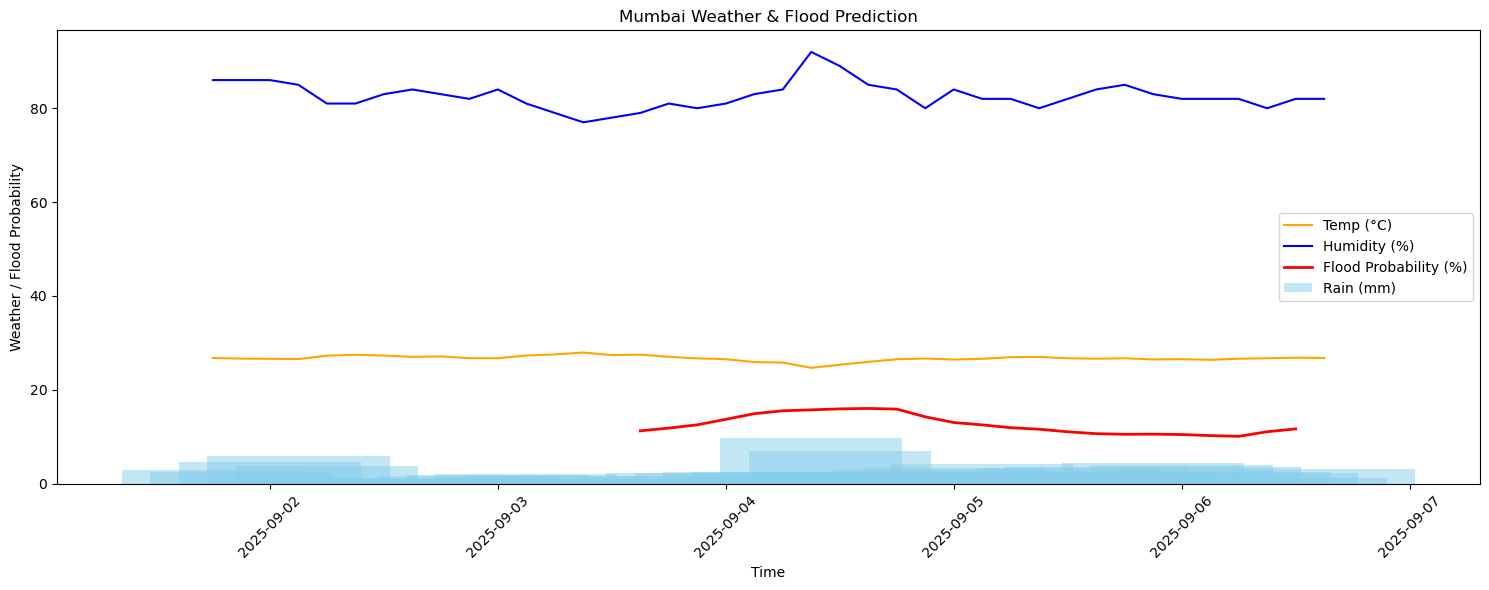

In [3]:
import matplotlib.pyplot as plt

# Predict flood probability for all sequences
flood_probs = model.predict(X).flatten()

# Align time axis
flood_times = df['time'][seq_len + pred_gap - 1 : seq_len + pred_gap - 1 + len(flood_probs)]

plt.figure(figsize=(15,6))

# Plot temperature
plt.plot(df['time'], df['temp'], label='Temp (°C)', color='orange')

# Plot humidity
plt.plot(df['time'], df['humidity'], label='Humidity (%)', color='blue')

# Plot rain
plt.bar(df['time'], df['rain'], label='Rain (mm)', color='skyblue', alpha=0.5)

# Plot flood probability
plt.plot(flood_times, flood_probs*100, label='Flood Probability (%)', color='red', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Weather / Flood Probability")
plt.title("Mumbai Weather & Flood Prediction")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
